<div align=center>
		
<font size=5>
In the Name of God
<font/>
<p></p>
<br/>
<br/>
<font color=#FF7500>
Sharif University of Technology - Departmenet of Computer Engineering
</font>
<p></p>
<font color=blue>
Artifical Intelligence - Dr. Mahdieh Soleimani
</font>
<br/>
<br/>
Fall 2022

<hr/>
<font color=red>
Reinforcment Learning Practical Assignment (50 + 10 points)
</font>
</div>

<ul>
  <li>Some cell's outputs have not been deleted. you can use these to make sure your implementation is correct.</li>
</ul>

In this notebook you will use the [openai gym](https://www.gymlibrary.dev/) library to train agents in two different reinforcment learning environments. the first environment is a very simple grid-world with discrete states. The second environment however, has continous states.  
make sure to upload your model performance video alongside this notebook. We suggest running this notebook on google colab so that you wont face any package errors.

we will first install the necessary packages.

In [1]:
!pip install gym==0.26
!pip install imageio imageio_ffmpeg
!pip install pygame
!pip install pyglet==1.5.1 
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip3 install pyvirtualdisplay

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-comm

the functions below will be used to make a video of the model performance. It will start the environment and choose the best action based on the given Qtable.

In [2]:
from IPython.display import HTML
from base64 import b64encode
import imageio

## comment this part if your not using google colab
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()
######################

def record_video_frozen_lake_env(env, Qtable, out_directory, fps=1, random_action=False):
  images = []  
  done = False
  state, info = env.reset(seed=random.randint(0,500))
  img = env.render()
  images.append(img)
  while not done:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.random.randint(4)  if random_action else np.argmax(Qtable[state][:])
    state, reward, done, truncated, info = env.step(action)
    img = env.render()
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

def show_video(video_path, video_width = 600):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

## Part I: FrozenLake Environment (35 + 10 Points)

In [3]:
import numpy as np
import gym
import random
from tqdm.notebook import tqdm

In this exercise, we want to solve the FrozenLake environment. It is a simple grid-world environment where we have to reach a goal state while avoiding holes.  
You can read more about this environment [here](https://www.gymlibrary.dev/environments/toy_text/frozen_lake/)

**[Question 1 (1 Points)]**  
Create a <u>slippery</u> FrozenLake environment of size <u>4x4</u>

In [4]:
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True, render_mode='rgb_array')

Let's run a random policy in this environement to get a better understanding of it.

In [5]:
record_video_frozen_lake_env(env, None, 'frozenlake_random.mp4', fps=1, random_action=True)
show_video('frozenlake_random.mp4', video_width = 600)

**[Question 2 (1 Points)]**  
Briefly describe the state space, action space, and reward function of this environment.

**Answer:**  
State space: 16 states depending on the location of the agent</br>
Action space: Four actions of right, left, up, down for every state<br>
Reward function (according to the documentation): goal=1, hole=0, frozen=0 

**[Question 3 (2 Points)]**  
Complete the code for `initialize_q_table` function. It should create a Q-table of size (state_space, action_space) and initializes it. You are free to use whichever initialization you want (a good starting point is to initialize it with all zeros)

In [6]:
def initialize_q_table(state_space, action_space):
  Qtable = np.zeros((state_space ** 2, action_space))
  return Qtable

In [7]:
Qtable = initialize_q_table(4, 4)

**[Question 4 (2 Points)]**  
Complete the code for `epsilon_greedy_policy` function. It should select the best action according to the current Q-function with probability $1-\varepsilon$ and select a random action with probability $\varepsilon$.

In [8]:
def epsilon_greedy_policy(Qtable, state, epsilon):
  if np.random.rand() <= 1 - epsilon:
    action = np.argmax(Qtable[state])
  else:
    action = np.random.randint(Qtable.shape[1])
  return action

**[Question 5 (4 Points)]**  
You need to choose appropriate hyperparameters for the agent to learn.

In particular, you must find a suitable learning rate and exploration parameters. To facilitate exploration, a common practice is to start with a high exploration rate ($\varepsilon$) and gradually decrease it as the agent gets better. To implement this, you need to specify the starting exploration rate (`max_epsilon`), the final exploration rate (`min_epsilon`) and a decay rate which reduces the exploration rate after each update (see the `train` function below).

In [9]:
# Training parameters
n_training_episodes = 50_000  # Total training episodes
n_eval_episodes = 10_000
learning_rate = 0.8          # Learning rate

# Environment parameters
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.002            # Exponential decay rate for exploration prob

**[Question 6 (10 Points)]**  
Complete the `train` function which updates `Qtable` using the Q-learning update rule.

In [10]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  for episode in tqdm(range(n_training_episodes)):
    # Adjust epsilon
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    # Reset the environment
    state, info = 0, env.reset()
    step = 0
    done = False

    # repeat
    for step in range(max_steps):
      # You must:
      # Take action A_t and observe R_{t+1}, S_{t+1}
      # Update the Qtable with (S_t, A_t, R_{t+1}, S_{t+1})
      # Be careful about episode termination and truncation
      action = epsilon_greedy_policy(Qtable, state, epsilon)
      observation, reward, terminated, truncated, info = env.step(action)
      Qtable[state][action] += learning_rate * (reward + gamma * np.max(Qtable[observation]) - Qtable[state][action])
      if terminated:
        break
      state = observation
  return Qtable

We are now ready to train our agent.

In [11]:
Qtable = initialize_q_table(4, 4)
Qtable_trained = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable)

  0%|          | 0/50000 [00:00<?, ?it/s]

Now, we will evaluate our agent. You don't need to write any code, just run the following cells as they are.

In [12]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param Q: The Q-table
  """
  episode_rewards = []
  for episode in tqdm(range(n_eval_episodes)):
    state, info = env.reset()
    step = 0
    terminated = False
    total_rewards_ep = 0
    
    for step in range(max_steps):
      action = np.argmax(Q[state][:])
      new_state, reward, terminated, truncated, info = env.step(action)
      total_rewards_ep += reward
        
      if terminated:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

In [13]:
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_trained)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}") # should be around 0.65

  0%|          | 0/10000 [00:00<?, ?it/s]

Mean_reward=0.71 +/- 0.45


Now let's see how well our model is doing.

In [14]:
record_video_frozen_lake_env(env, Qtable_trained, 'frozenlake_trained.mp4', fps=1)
show_video('frozenlake_trained.mp4', video_width = 600)

Next, we will take a look at the Q-function that was learned.

In [15]:
print(Qtable_trained)

[[4.59782365e-01 4.22539020e-02 3.52572688e-02 1.13298227e-01]
 [3.87698078e-03 4.86490616e-04 5.09290735e-03 1.35531094e-01]
 [1.96183751e-02 4.75242802e-03 1.12469171e-01 2.56794417e-02]
 [1.28722688e-02 4.11975194e-03 1.42046792e-02 3.69685513e-02]
 [5.74466814e-01 3.37043420e-02 1.04126165e-01 4.38790225e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [7.39720941e-02 1.55472931e-06 2.01914901e-06 3.93526805e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.07972921e-02 1.43599311e-02 1.36059659e-02 5.91631864e-01]
 [7.01519656e-03 4.32452239e-01 6.34956758e-06 8.54817153e-03]
 [7.38561219e-01 3.50999337e-05 5.58305900e-03 2.58554014e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.73798550e-02 1.20969155e-02 7.49530940e-01 1.68623997e-02]
 [3.30413618e-01 9.72894982e-01 7.63617478e-01 2.91247570e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.000000

**[Question 7 (5 Points)]**  
Assume that `Qtable_trained` is the correct Q-function for the final epsilon-greedy policy that was used in training. What is the value function that corresponds to this policy? Write down the relation between $V_\pi$ and $Q_\pi$ and use it to complete the following code block.

**Answer:**
$$V_\pi (s) = \max_{a}Q_\pi(s, a)$$

In [16]:
Vtable_trained = np.max(Qtable, axis=1)

Take a look at the value function

In [17]:
print(Vtable_trained)

[0.45978236 0.13553109 0.11246917 0.03696855 0.57446681 0.
 0.07397209 0.         0.59163186 0.43245224 0.73856122 0.
 0.         0.74953094 0.97289498 0.        ]


**[Question 8 (5 Points)]**  
Write a function to generate a visualization for the value function using a heatmap. In a few words, explain what you see.

In [18]:
import matplotlib.pyplot as plt

def visualize(Vtable):
  plt.imshow(np.reshape(Vtable, (-1, 4)), cmap='Greens')
  plt.show()

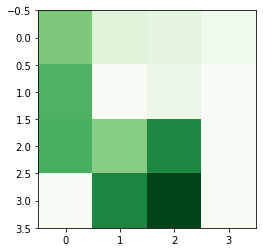

In [19]:
visualize(Vtable_trained)

**[Question 9 (5 Points)]**  
Can we use a pure greedy policy for Q-learning? Explain.

**Answer:**

using pure greedy will result in reduced exploration, as a result the algorithm might not find the best possible Q value for some Q's.

**[Bonus Question (10 Points)]**  
Think about the role of the discount factor in this environment and experiment.  
1. Explain why it is not the best idea to set $\gamma = 1$ for a navigation task. You might find it easier to reason about a deterministic (i.e., non-slippery) environment. (5 Points)
2. If we had used $\gamma = 1$, the value of states could be interpreted in a meaningful way. Think about what $V^*(s)$ would be if we had set $\gamma = 1$ and trained until we got the optimal value function. (5 Points)

**Answer:**
<ol>
<li>beacause if gamma = 1, the agent might never reach the goal state since it thinks that it will eventaually reach the goal state by going either way thus all such actions seem good enough since they will eventually reach the goal state and the agent may end up just going back and forth.</li>
<li>When gamma = 1, $V^*(s)$ would end up having the value that we expect to get in the long term if we started from state s, provided that we can do infinite number of actions.</li>
</ol>

# Part II: Mountain Car Environment (15 point)

The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill.

lets create the environment.

In [20]:
env = gym.make("MountainCar-v0", render_mode='rgb_array')

The state of the car is represented by its velocity and position along the x axis. the velocity is a number between -0.07, 0.07 and the position is a number between -1.3, 0.6. There are 3 discrete deterministic actions: (0:Accelerate to the left, 1:Don’t accelerate, 2:Accelerate to the right)
The starting position of the car is different each time we run the environment.

In order to use the same Q learning algorithm on this environment we need to somehow discretize the states. We can easily do this by dividing the range of the observation into smaller range.   
its important how small we divide these range. if the step size is too big we might not achieve a good accuracy and if the step size is too small we will have a bigger observation space.  

**[Question 10 (5 Points)]**  
implement the next  discretization function.

In [21]:
def discretize(x, min_value, step_size):
    return int((x - min_value) / step_size)

assert(discretize(0.222, 0.1, 0.1)==1)
assert(discretize(0.134, 0.1, 0.1)==0) 

we will use step size 0.1 for the position and the step size 0.01 for the velocity. the following function will discretize a state using the function you implemented above.

In [22]:
def discretize_state(state, step_velocity=0.01, step_position=0.1):
  position , velocity = state
  position = discretize(position, -1.3, step_position)
  velocity = discretize(velocity, -0.07, step_velocity)
  if position==19:
    position = 18
  if velocity==14:
    velocity = 13
  return (position, velocity)

the function below will run the mountain car experiment and output a video. We will use it to run an agent with a random policy.

In [23]:
def record_video_mountain_car_env(env, Qtable, out_directory, fps=1, random_action=False, max_episode=500):
  images = []  
  truncated, done = False, False
  state, info = env.reset(seed=random.randint(0,500))
  state = discretize_state(state)
  img = env.render()
  images.append(img)
  episode = 0
  while episode < max_episode and not done:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.random.randint(3)  if random_action else np.argmax(Qtable[state[0]][state[1]][:])
    state, reward, done, truncated, info = env.step(action)
    state = discretize_state(state)
    img = env.render()
    images.append(img)
    episode += 1
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

def show_video(video_path, video_width = 600):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

record_video_mountain_car_env(env, None, 'mountaincar_random.mp4', fps=15, random_action=True)
show_video('mountaincar_random.mp4', video_width = 600)

**[Question 11 (2 Points)]**  
Implement the next functions like you did the previous part. 

In [24]:
def initialize_q_table(step_size_velocity, step_size_pos, action_space):
  # Qtable should be of the shape (discrete position value, discrete velocity value, action_no)
  return np.zeros((int(np.ceil(1.9 / step_size_pos)), int(np.ceil(1.4 / step_size_velocity)), action_space))

def epsilon_greedy_policy(Qtable, state, epsilon):
  if np.random.rand() <= 1 - epsilon:
    return np.argmax(Qtable[state])
  return np.random.randint(Qtable[state].shape[0])

Qtable = initialize_q_table(0.01, 0.1, 3)

**[Question 12 (8 Points)]**  
Change the previous train function so it works in this environment.

In [25]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  for episode in tqdm(range(n_training_episodes)):
    # Adjust epsilon
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    # Reset the environment
    state, info = env.reset()
    state = discretize_state(state)
    step = 0
    done = False

    # repeat
    for step in range(max_steps):
      action = epsilon_greedy_policy(Qtable, state, epsilon)
      observation, reward, terminated, truncated, info = env.step(action)
      next_state = discretize_state(observation)
      Qtable[state][action] += learning_rate * (reward + gamma * np.max(Qtable[next_state]) - Qtable[state][action])
      if terminated:
        break
      state = next_state
  return Qtable

Now lets train our model. You can change the hyperparameters if you want.

In [26]:
# Training parameters
n_training_episodes = 20_000  # Total training episodes
learning_rate = 0.1           # Learning rate

# Environment parameters
max_steps = 200               # Max steps per episode
gamma = 0.95                 # Discounting rate

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 2e-3            # Exponential decay rate for exploration prob

In [27]:
Qtable_trained = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable)

  0%|          | 0/20000 [00:00<?, ?it/s]

Now let us inspect how well our model is doing. In order to pass the assignment, the car must reach the goal.

In [28]:
record_video_mountain_car_env(env, Qtable_trained, 'mountaincar_random.mp4', fps=15)
show_video('mountaincar_random.mp4', video_width = 600)